In [183]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)


tensorflow:1.2.1
__Python VERSION: 2.7.6 (default, Oct 26 2016, 20:30:19) 
[GCC 4.8.4]
__pyTorch VERSION: 0.2.0_1
__CUDA VERSION
__CUDNN VERSION: 6021
__Number CUDA Devices: 0
__Devices


In [184]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [224]:
DATA_ROOT ='/root/data/cifar/'
IMG_PATH = DATA_ROOT + '/train/'
IMG_EXT = '.png'
IMG_DATA_LABELS = DATA_ROOT + '/trainLabels.csv'

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [245]:
try:
    from PIL import Image
except ImportError:
    import Image
    
class GenericImageDataset(Dataset):    
    def __init__(self, csv_path, img_path, img_ext, transform=None):
                
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))
        lgr.info('IMG path {}'.format(img_path))        
        
        assert img_ext in ['.png']
        
        self.transform=transform
        tmp_df = pd.read_csv(csv_path, header=None) # I manually removed the header
        
        self.img_path = img_path
        self.img_ext = img_ext        

        self.X_train = tmp_df[0]                
        self.y_train = tmp_df[1]                
#         lgr.info("DF X_train:\n" + str (self.X_train.head(5)))
#         lgr.info ("DF y_train:\n" + str(self.y_train))
        

        lgr.info('[*] Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))

    def __getitem__(self, index):
        lgr.info ("__getitem__:" + str(index))
        
        if self.X_train[index]=='id':
            path=self.img_path + str(300) + self.img_ext     
        else:    
            path=self.img_path + str(self.X_train[index]) + self.img_ext
            
#         lgr.info (" --- get item path:" + path)
        img = Image.open(path)
        if self.transform is not None:                                     
            img = self.transform(img)
            
        label = self.y_train[index]
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
#         lgr.info ("Lenght:" +str(l))
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0

In [246]:
# transformations = transforms.Compose([transforms.ToTensor()])
transformations = transforms.Compose([transforms.Scale(32),transforms.ToTensor()])

In [253]:
dset_train = GenericImageDataset(IMG_DATA_LABELS,
                                 IMG_PATH,
                                 IMG_EXT,transformations)

train_loader = torch.utils.data.DataLoader(dset_train, batch_size=1,
                                          shuffle=False, num_workers=1)

INFO:__main__:CSV path /root/data/cifar//trainLabels.csv
INFO:__main__:IMG path /root/data/cifar//train/
INFO:__main__:[*] Dataset loading time 0.051173210144
INFO:__main__:[*] Data size is 50001


INFO:__main__:__getitem__:0
INFO:__main__:__getitem__:1
INFO:__main__:i=0: 
INFO:__main__:__getitem__:2
INFO:__main__:__getitem__:3
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:__getitem__:4
INFO:__main__:i=3: 
INFO:__main__:__getitem__:5


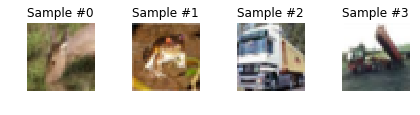

In [254]:
imagesToShow=4

for i, data in enumerate(train_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    